In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load the dataset
file_path = 'merged_TimeWVHT_data.csv'
df = pd.read_csv(file_path)

In [4]:
# Step 1: Data Preprocessing
# Combine time features
# Ensure column names are correctly referenced (strip spaces or special characters if necessary)
df.rename(columns={'#YY': 'Year', 'MM': 'Month', 'DD': 'Day'}, inplace=True)

# Convert to datetime
df['DateTime'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Drop original year, month, day columns if no longer needed
df = df.drop(columns=['Year', 'Month', 'Day'])

# Sort by time
df = df.sort_values('DateTime')

# Scaling features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['ATMP', 'WTMP', 'WVHT']])
df[['ATMP', 'WTMP', 'WVHT']] = scaled_data

# Prepare sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, :-1])
        y.append(data[i + sequence_length, -1])
    return np.array(X), np.array(y)

sequence_length = 30  # Use past 30 days
data = df[['ATMP', 'WTMP', 'WVHT']].values
X, y = create_sequences(data, sequence_length)

# Split into training and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]


In [14]:
# Step 2: Model Design
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# Step 3: Training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0898 - val_loss: 0.0239
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0200 - val_loss: 0.0199
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0164 - val_loss: 0.0192
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0144 - val_loss: 0.0150
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0155 - val_loss: 0.0152
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0134 - val_loss: 0.0154
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0133 - val_loss: 0.0148
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0133 - val_loss: 0.0144
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0129 - val_loss: 0.0159
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0130 - val_loss: 0.0148
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0129 - val_loss: 0.0155
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

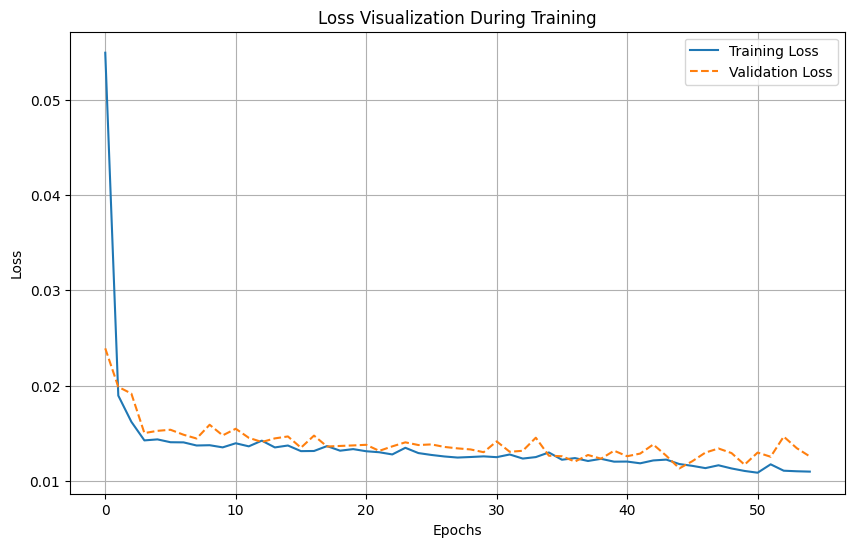

In [16]:
# Step 4: Loss Visualization (Add the following code here)
import matplotlib.pyplot as plt

# Extract loss and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Visualization During Training')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


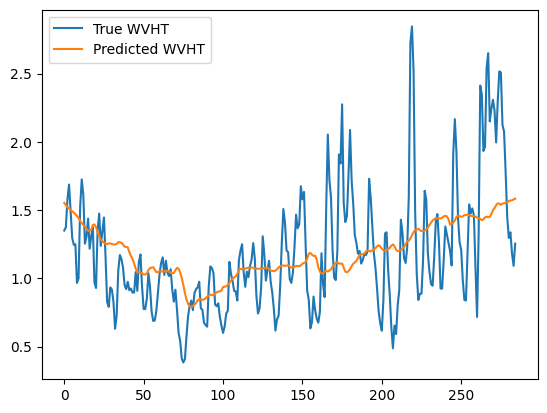

In [13]:
# Step 4: Evaluation
predicted = model.predict(X_val)
y_val_inv = scaler.inverse_transform(np.concatenate((np.zeros((y_val.shape[0], 2)), y_val.reshape(-1, 1)), axis=1))[:, -1]
predicted_inv = scaler.inverse_transform(np.concatenate((np.zeros((predicted.shape[0], 2)), predicted), axis=1))[:, -1]

# Visualization
import matplotlib.pyplot as plt

plt.plot(y_val_inv, label='True WVHT')
plt.plot(predicted_inv, label='Predicted WVHT')
plt.legend()
plt.show()